<a href="https://colab.research.google.com/github/tomonari-masada/course2025-intro2ml/blob/main/10_SVM_%E6%8E%88%E6%A5%AD%E4%B8%AD20250707.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# パーセプトロンとSVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

%config InlineBackend.figure_format = 'retina'

## MNISTデータを使う

* 関数`sklearn.datasets.fetch_openml`を利用してMNISTデータをダウンロードする。

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X, y = mnist.data, mnist.target

In [4]:
print(X.shape, y.shape)

(70000, 784) (70000,)


* 通常、MNISTデータは最後の10000件をテストデータとして使う。

In [5]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

* テストデータ以外の60000件を、訓練データ50000件と検証データ10000件へ分割しておく。

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=10000,
    random_state=42,
)

In [7]:
print(X_train.shape, X_val.shape, X_test.shape)

(50000, 784) (10000, 784) (10000, 784)


* 訓練データの最初の100個を可視化してみる。

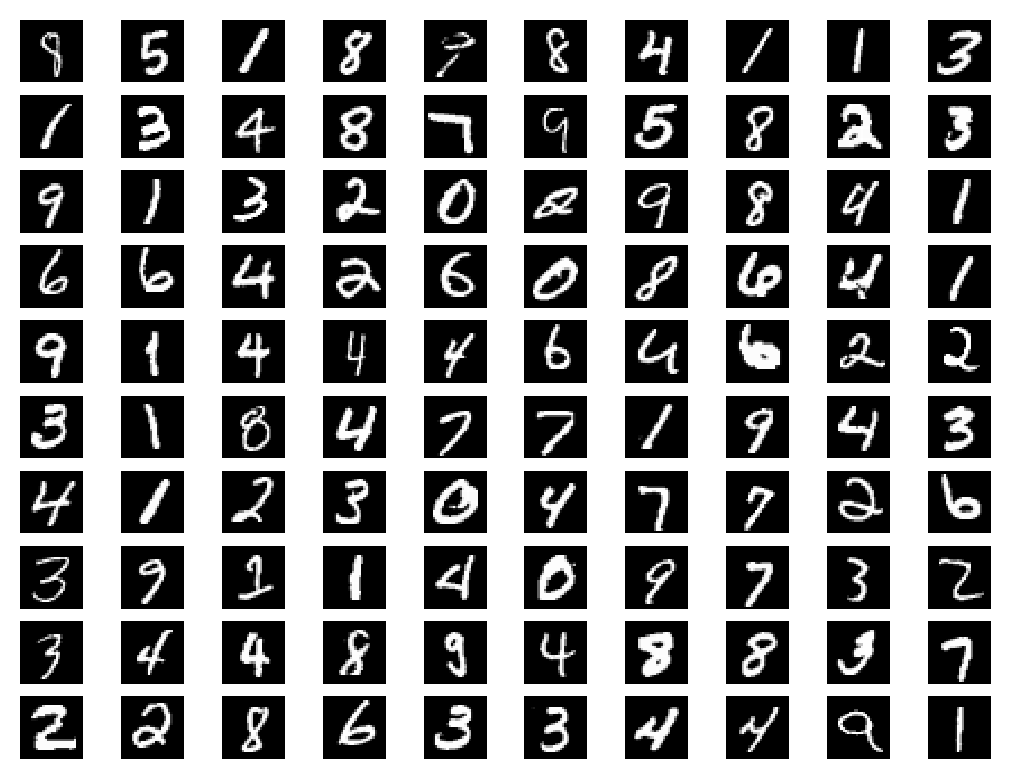

In [8]:
fig, axes = plt.subplots(10, 10)
for x, ax in zip(X_train.values, axes.ravel()):
  ax.axis('off') # 軸を消す
  ax.matshow(x.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

* 問題を2値分類問題に変える。
  * 0とそれ以外の2値分類問題にしてしまう。

* その前に、元の正解ラベルをコピーしておく。

In [9]:
y_train_original = y_train.copy()
y_val_original = y_val.copy()
y_test_original = y_test.copy()

In [10]:
y_train = (y_train != '0') * 1
y_val = (y_val != '0') * 1
y_test = (y_test != '0') * 1

In [11]:
print(f'{(y_train == 0).sum()} zero digits and {(y_train == 1).sum()} non-zero digits in training set')

4939 zero digits and 45061 non-zero digits in training set


## パーセプトロンによる分類の実行
* `sklearn.linear_model.Perceptron`クラスを使う。

## パーセプトロンでの正則化
* scikit-learnのパーセプトロンでは、`alpha`というパラメータを調整する。
  * リッジ回帰やLassoの`alpha`と同じ。大きいほど正則化が強く効く。
* 正則化の種類は`penalty`を`'l2'`か`'l1'`に設定することでおこなう。
  * `l2`だと、係数の二乗の和を最小化する。
  * `l1`だと、係数の絶対値の和を最小化する。

In [12]:
clf = Perceptron()
clf.fit(X_train, y_train)

Perceptron()

In [13]:
clf.coef_

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.3000e+01,  3.0700e+02, -3.5000e+02,
        -1.8510e+03, -8.8300e+02,  2.2600e+02,  4.7000e+01,  2.1600e+02,
         1.0500e+02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3000e+01,
        -1.0000e+01,  1.7900e+02,  1.1380e+03,  1.2620e+03,  1.2610e+03,
         3.5120e+03,  4.2010e+03,  3.9190e+03,  3.2

In [14]:
clf.intercept_

array([1230.])

In [15]:
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

Accuracy: 0.9842


In [16]:
clf = Perceptron(penalty="l2", alpha=0.01)
clf.fit(X_train, y_train)

Perceptron(alpha=0.01, penalty='l2')

In [17]:
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

Accuracy: 0.9341


## SVMによる分類の実行
* ここでは、`LinearSVC`クラスを使う。
  * `SVC`クラスを使ってもよい。
  * `SVC`クラスを使うと、カーネルを指定できる。
* 分類器を準備し、訓練データを渡して係数と切片を推定させる。
  * 訓練データの個数が多いので、少し時間がかかる。
  * 推定計算が収束しない場合は、`max_iter`を増やしてみる。

## SVMでの正則化
* scikit-learnの`LinearSVC`では、`C`というパラメータを調整する。
  * https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
* `C`は、小さいほど、正則化が強く効く＝係数をより強くゼロに近づける。
  * デフォルトの設定は`C=1.0`。
  * リッジ回帰やLassoの`alpha`とは、向きが逆であることに、注意。

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train) # Google Colabでも1分以内には終わる。

In [ ]:
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

* 推定された係数を可視化してみる。
 * 0とそれ以外を分類するとき、どのピクセルが有効かが見えるかも。

In [ ]:
plt.imshow(clf.coef_.reshape(28,28), cmap=plt.cm.gray);

* パラメータ`C`の値を変えつつ試行錯誤する。

In [ ]:
clf = LinearSVC(C=0.1)
clf.fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

## 見つけ出した最善の設定を使ってテストデータ上で評価


In [ ]:
X_train_val = np.concat((X_train, X_val))
y_train_val = np.concat((y_train, y_val))

In [ ]:
clf = LinearSVC()
clf.fit(X_train_val, y_train_val)
print(f'Accuracy: {clf.score(X_test, y_test):.4f}')

## Stochastic Gradient Descent (SGD) を使う方法

* 実は、ロジスティック回帰モデルやSVMの学習を、より効率よく行う方法がある。
* それは、sklearn.linear_model.SGDClassifierを使う方法である。

### ロジスティック回帰の学習と同等の学習
* `SGDClassifier`を`loss="log_loss"`という設定で使う。

In [ ]:
clf = SGDClassifier(loss="log_loss")
clf.fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

* 正則化の併用
  * `penalty`は`"l1"`に設定しても`"l2"`に設定しても、どちらでも良い。

In [ ]:
clf = SGDClassifier(loss="log_loss", penalty="l2", alpha=0.01)
clf.fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

### SVMの学習と同等の学習
* `SGDClassifier`を`loss="hinge"`かつ`penalty="l2"`という設定で使う。
  * `penalty="l2"`以外の設定だと、SVMと同等にならない。

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

* 正則化の併用

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.01)
clf.fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_val, y_val):.4f}')

# 課題20250714
* 分類モデルとして`LinearSVC`を使ったとき・・・
* 検証データでの正解率が良くなるように、パラメータ`C`の値をチューニングしよう。
* その`C`の値を使って、テストデータでの正解率を求めよう。



---



# SVMによる多値分類
* 元の10値分類、つまり「0」〜「9」の10種類のカテゴリへの分類は・・・
* 実は、元のデータをそのまま使うだけで実現できる。

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train_original) # Google Colabでは3分弱かかります。
print(f'Accuracy: {clf.score(X_val, y_val_original):.4f}')